In [1]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.model_selection

# Cross-entropy loss

So far we used mean squared error (MSE) loss. In this notebook, I would like to show you cross-entropy loss, that is more suited for the classification problems. Mean squared error is preferred loss if we perform regression (we try to predict real number), but for the classification task, when we should predict in which class the example is from, the cross-entropy is much better. We will see why is this way through this notebook.

We may take cross-entropy loss into more details, however, I don't think it is necessary. Still, I would like to point out some articles, that should be a good starting point, when somebody wants to know deeper, what is really happening.

First of all, you may want to know something about entropy itself. This is probably term you already heard about during statistics, cybersecurity or information theory in general. It basically describes, how much "surprise" is in the data. The article [[1]](#Bibliography) is a good starting point.

Then there is cross entropy. When we have two distributions, cross entropy in some sense measure difference between these distributions. We may think about the target classes as about one of the distribution and about the model prediction as about the second distribution. Our goal is to align the model prediction distribution as close as possible to the target distribution. Now you may see, why the cross entropy may be better idea compare to MSE. YOu may find some more math and in-depth view in [[2]](#Bibliography).

Finally, simmilar to MSE, we may derive cross-entropy as result of maximum likelihood estimation. So we have ways to show, that the cross-entropy is a good loss function and that it works. 

Let's get to math. Cross entropy is defined as follow:
$$
H(P,Q)=-\sum_{x\in X}^{n}p(x)\log q(x)
$$

Remember, we are talking about the distributions. Here, the $P$ is the target distribution and $Q$ is the model distribution. As such $p(x)$ and $q(x)$ is not a single number, but a vector - distribution over all the classes. If we want to know, how to compute cross-entropy for a single example, the formulas is following:
$$
\mathcal{L}(t, y)=-\sum_i t_i \log y_i 
$$

Here, the $t$ is the target distribution and $y$ is the predited distribution. Let's show it on the example. Let's say we have example, where the target should be equal to second class. If we want to express this in the distribution, that would equal to vector $t=(0,1,0,0)$ (I consider only 4 classes). Now, the model predicted $y=(0.2, 0.1, 0.5, 0.2)$. The cross-entropy in this case is following:
$$
\mathcal{L} = -(0 \cdot \log 0.2 + 1 \cdot \log 0.1 + 0 \cdot \log 0.5 + 0 \cdot \log 0.2) = - 1 \cdot \log 0.1 = 2.30259 
$$
On the other hand, if the correct class would be third one (that is $t=(0,0,1,0)$), the cross-entropy would change.
$$
\mathcal{L} = -(0 \cdot \log 0.2 + 0 \cdot \log 0.1 + 1 \cdot \log 0.5 + 0 \cdot \log 0.2) = - 1 \cdot \log 0.5 = 0.69314
$$

As we may see, the closer the prediction is to the target distribution, the lower the loss.

# Binary cross-entropy loss

Firstly, let's look at the binary cross-entropy. That is loss, that takes into account only two classes - exactly what we were doing so far. There doesn't matter, we have only one class, as we may compute the probability of the second class as complement $1 - p$. Here comes the final loss:

$$
\mathcal{L}_{BCE}(t,y)=-t\log y - (1-t)\log (1-y)
$$

I just expand the sum to both classes and computed distribution of the second class as complement of the first one. Now it is simple to get the derivative as well.

$$
\frac{\partial \mathcal{L}}{\partial y}= -\frac{t}{y} + \frac{1-t}{1-y}
$$

There is however one problem. What if prediction is equal exactly $0$ or $1$? ALthough that is impossible, when sigmoid is used, the precision of float value may not hold that small value and just round the result to either $0$ or $1$. In that case, the fractions are not defined. Because of that, usually some small $\varepsilon$ is add to the denominator.

Now we know enough, so we may check the implementation.

In [2]:
class BCELoss:
    def __call__(self, target, predicted):
        return np.sum(-target * np.log(np.maximum(predicted, 1e-15)) - (1 - target) * np.log(np.maximum(1 - predicted, 1e-15)), axis=0)
    def gradient(self, target, predicted):
        return - target / (np.maximum(predicted, 1e-15)) + (1 - target) / (np.maximum(1 - predicted, 1e-15))

We may now compare binary cross-entropy with mean squared error loss. Firstly, let's download the data.

In [3]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
one_or_seven_indices = np.logical_or(y == 4, y == 9)
data = X[one_or_seven_indices].reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
target = y[one_or_seven_indices].reshape(-1)
target[target==4] = 0
target[target==9] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.3, random_state=47)

Then let's define `MSELoss` the same way as in the previous notebook.

In [4]:
class MSELoss:
    def __call__(self, target, predicted):
        return np.sum((target - predicted) ** 2, axis=0)
    def gradient(self, target, predicted):
        return -(target - predicted)
    
class AccuracyMetric:
    def __init__(self, name=None):
        self.name = name or "accuracy"
        self.correct = 0
        self.num = 0
    def __call__(self, target, predicted):
        self.correct += np.sum((predicted >= 0.5) & (target == 1)) + np.sum((predicted < 0.5) & (target == 0))
        self.num += len(target)
    def summary(self):
        acc = self.correct / self.num
        self.correct = 0
        self.num = 0
        return acc

Finally, we may use the `Neuron` class from the previous notebook and pass different loss to the cosntructor.

In [5]:
from src.neuron_05 import Neuron

mse = Neuron(loss=MSELoss(), metrices=[AccuracyMetric()], epochs=2000, learning_rate=0.001, batch_size=128, random_state=42)
mse_result = mse.fit(train_data, train_target, test_data, test_target, progress=True)

100% (2000 of 2000) |####################| Elapsed Time: 0:01:18 Time:  0:01:18


In [6]:
from src.neuron_05 import Neuron

bce = Neuron(loss=BCELoss(), metrices=[AccuracyMetric()], epochs=2000, learning_rate=0.001, batch_size=128, random_state=42)
bce_result = bce.fit(train_data, train_target, test_data, test_target, progress=True)

100% (2000 of 2000) |####################| Elapsed Time: 0:01:24 Time:  0:01:24


All we need to do now is to plot the data.

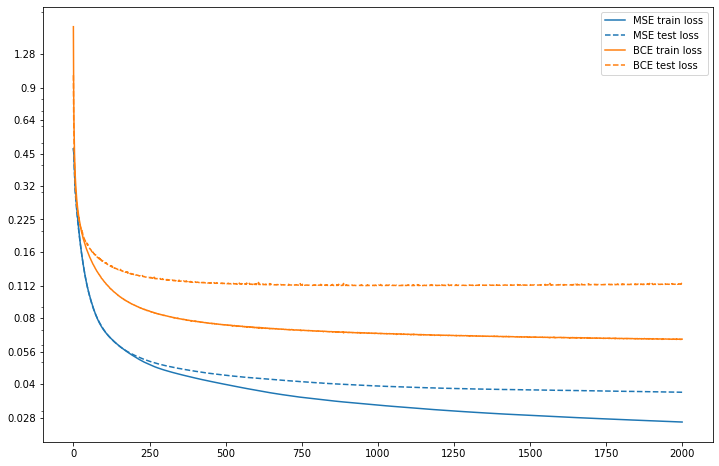

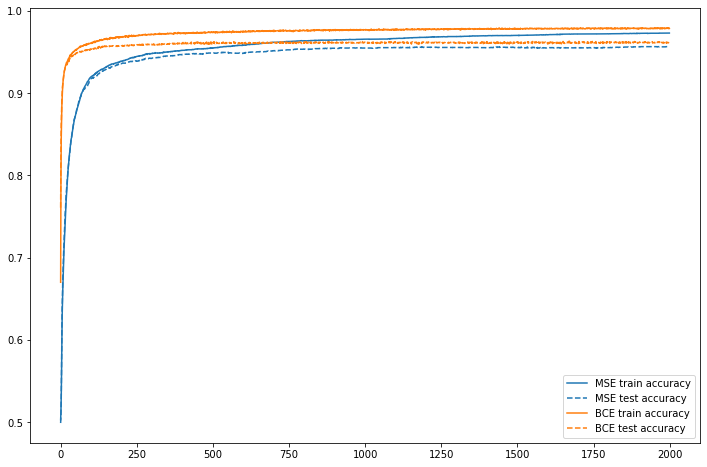

In [7]:
plt.figure(figsize=(12,8))
plt.plot(mse_result['train_loss'], label="MSE train loss", color='tab:blue')
plt.plot(mse_result['test_loss'], label="MSE test loss", color='tab:blue', linestyle='--')
plt.plot(bce_result['train_loss'], label="BCE train loss", color='tab:orange')
plt.plot(bce_result['test_loss'], label="BCE test loss", color='tab:orange', linestyle='--')
plt.yscale('log')
ticks = [0.028, 0.04, 0.056, 0.08, 0.112, 0.16, 0.225, 0.32, 0.45, 0.64, 0.9, 1.28]
plt.yticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(mse_result['train_accuracy'], label="MSE train accuracy", color='tab:blue')
plt.plot(mse_result['test_accuracy'], label="MSE test accuracy", color='tab:blue', linestyle='--')
plt.plot(bce_result['train_accuracy'], label="BCE train accuracy", color='tab:orange')
plt.plot(bce_result['test_accuracy'], label="BCE test accuracy", color='tab:orange', linestyle='--')
plt.legend()
plt.show()

That is interesting. Although BCE loss is much higher compared to MSE, accuracy is better for binary cross-entropy loss. Loss values can't be directly compared, when different loss, architecture or regularization is used. Performance of the network should be determined by some metric, now we see why.

## Why is binary cross-entropy loss better than MSE loss

We may notice something much more interesting. BCE accuray increased much faster in comparison to MSE loss, although the model is the same. Why is it? This fact is connected to usage of sigmoid and binary cross entropy. If you remember the sigmoid graph and it's derivative.

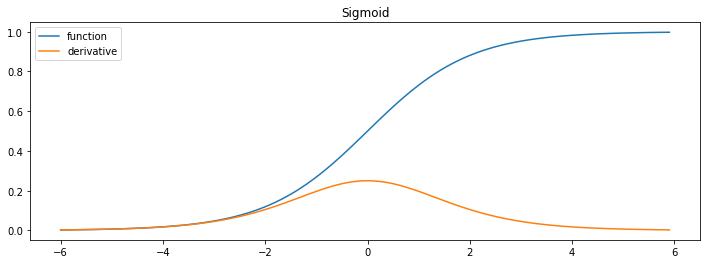

In [8]:
def sig(x):
    return 1 / (1 + np.exp(-x))
x = np.arange(-6, 6, 0.1)
plt.figure(figsize=(12,4))
plt.plot(x, sig(x), label="function")
plt.plot(x, sig(x)*(1-sig(x)), label="derivative")
plt.title("Sigmoid")
plt.legend()
plt.show()

You may notice, that values far away from zero have almost 0 derivative. When MSE loss is used, the derivative of MSE won't be greater that 1. Derivative of sigmoid is lower than $0.25$ - probably less, when the missclassified example is too far. As a result, gradient of weights is too small and take some time to "shift" the example to the correct side of the sigmoid.

On the other hand, when binary cross-entropy loss is in use, the derivative is $\frac{t}{y}=\frac{1}{y}$ for the correct class. When the example is missclassified too much ($y$ is very small), the higher is the resulting derivative. As such, for very wrongly missclassified examples, the weights are updated more, as this fraction balance the sigmoid.

We may look at it from the other view. Sigmoid is exponential function and binary cross-entropy is logarithmic fucntion. When we put this together, they balance each other and we may think about the resulting gradient in "linear scale".

As a result of better gradient propagation, model with binary cross-entropy learns faster from the beginning.

I will talk about similar topics later on.

# Multiclass cross-entropy

It is easy to generalize our loss to more classes. Remember, how the cross-entropy looked like.

$$
\mathcal{L}(t, y)=-\sum_i t_i \log y_i 
$$

We may directly implement it, we are going to call it `CategoricalCrossEntropyLoss`. Let's expand the sum, so we can better see what is happening.

$$
\mathcal{L}(t, y)=-t_0 \log y_0 - t_1 \log y_1 - t_2 \log y_2 - \cdots - t_9 \log y_9 
$$

Notice, that the target distribution $\pmb{t}$ is one-hot encoded, that is, the vector $\pmb{t}$ would be something like $(0,0,0,1,0,0,\dots,0)$. As the zeros remove corresponding classes from the loss, we end up with simplified version.

$$
\mathcal{L}(t, y)=-t_r \log y_r 
$$

where $r$ is the index of the correct class. Moreover, $t_r$ in this case is $1$, so the loss is even simpler.

$$
\mathcal{L}(t, y)=-\log y_r 
$$

This is something, you may know as a negative log likelihood, I will talk about it in a moment. Finally, derivative of the loss is very simple.

$$
\frac{\partial \mathcal{L}}{\partial y_r} = -\frac{1}{y_r} \\
\frac{\partial \mathcal{L}}{\partial y_{i \neq r}} = 0
$$

So, here is the resulting code, that reflects these changes.

In [1]:
class CategoricalCrossEntropyLoss:
    def __call__(self, target, predicted):
        indices = np.arange(len(target))
        return -np.log(np.maximum(predicted[indices,target], 1e-15))
    
    def gradient(self, target, predicted):
        grad = np.zeros((len(target), 10))
        indices = np.arange(len(target))
        grad[indices,target] = -1 / np.maximum(predicted[indices,target], 1e-15)
        return grad

We are not going to use this loss yet, but we will see it in action in the following notebook. The `np.maximum` calls are there only for stability, in case the value is $0$ and the division would be undefined.

Note that the `predicted` parameter is expected to have shape `(examples,classes)`, whereas the `target` parameter is expected to be in shape `(examples)` with values up to number of classes.

Also note that the loss is interested in only one output. For each example, the loss is computed only on the correct class (if the model predicted other class with higher probability, the loss doesn't care about it) as well as the gradient updates only one input. The cross-entropy expect, that each class would justify itself. 

# Cross-entropy and negative log likelihood

There is sometimes confusion about cross-entropy loss and negative log likelihood loss. Probably because of Pytorch, that has both of these losses. The fact is, that there are the same.

Although I didn't want to dive deeper into the math behind, it is best to do it for the negative log likelihood.

Firstly, let's start with the maximum-likelihood. That is, we want to find parameters, thats best explain the data.
$$
\theta_{ML} = \underset{\theta}{\arg\max}\ p_{model}(\pmb{X}_{examples}; \theta)
$$

As examples are independ of each other, we may rewrite that.

$$
\theta_{ML} = \underset{\theta}{\arg\max}\ \prod_{i} p_{model}(x_i; \theta)
$$

Mathematicians usually don't like multiplication, so we wanna get rid of it. Luckily, multiplication of numbers is the same (in the sense of optimization) as summation of logarithms.

$$
\theta_{ML} = \underset{\theta}{\arg\max}\ \sum_{i} \log p_{model}(x_i; \theta)
$$

Finally, maximalization of $x$ is equal to minimalization of $-x$.

$$
\theta_{ML} = \underset{\theta}{\arg\min}\ \sum_{i} - \log p_{model}(x_i; \theta)
$$

Here we see, why we call it **negative log likelihood** loss. 

However, we are still not there. This is still something different that what I showed as cross entropy. What we may do is divide the sum by number of examples, as the scaling of the values doesn't affect the optimization process.

$$
\theta_{ML} = \underset{\theta}{\arg\min}\ \sum_{i}^{n} - \frac{1}{n} \log p_{model}(x_i; \theta)
$$

But that is definition of expectation value (what would be the expected outcome for all the data). In other word, what would be the expected output if we sample the data from the examples. We may express is as following formula.

$$
\theta_{ML} = \underset{\theta}{\arg\min}\ \mathbb{E}_{x \sim p_{example}(x)} \log p_{model}(x; \theta)
$$

We are almost there. We can now see two probability distributions - there is $p_{example}(x)$ distribution (i will denote $p_t(x)$ as it is our target distribution) and $p_{model}(x)$ distribution (i will denote as $p_y(x)$ as it is the model prediction distribution). Now I just make these changes.

$$
\theta_{ML} = \underset{\theta}{\arg\min}\ \mathbb{E}_{x \sim p_t(x)} \log p_y(x; \theta)
$$

This is the exact definition of cross entropy.

Last step to get our loss is to rewrite the expected value by definition. For one example, where $t$ are individual classes:

$$
\mathbb{E}_{x \sim p_t(x)} \log p_y(x; \theta) = \sum_k p_t(k) \log p_y(k)
$$

And that's exactly, where we wanted to end up - the cross entropy alias the negative log likelihod (**NLL**) loss. 

Wow, that was a lot of math. You don't need to remember it, I just wanted to point out, that you may encounter negative log likelihood loss and that it is in fact the same thing as cross-entropy.

# Bibliography

 - \[1\] Entropy in machine learning, Francesco Gadaleta, 6 May 2019, [online](https://amethix.com/entropy-in-machine-learning/)
 - \[2\] A Gentle Introduction to Cross-Entropy for Machine Learning, Jason Brownlee, 21 October 2019, [onlin](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)
 - \[3\] Cross-entropy and Maximum Likelihood Estimation, Roan Gylberth, 16 February 2019, [online](https://medium.com/konvergen/cross-entropy-and-maximum-likelihood-estimation-58942b52517a).